# Building a model for predicting success of a Kickstarter project

**Question 4: What features have the greatest influence on success?**

**Question 5: Can we predict success of current/future projects?**

To answer both of these questions, I can use machine learning to create a logistic regression model. First I need to clean the data and then pre-process it.

### Clean the data

In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import kickstarter_functions as kf
import kickstarter_ML as kml

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
# load in csv file as dataframe
df = pd.read_csv('ks-projects-201801.csv')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Since I'm interested in modelling how these features can predict success vs. failure, I only want to keep the projects that completed as 'successful' or 'failed'.

In [3]:
df_clean = df.copy()

In [4]:
# drop unfinished or undefined projects
unfinished = ['canceled','undefined','live','suspended']

df_clean = df_clean[~df_clean.state.isin(unfinished)]

In [5]:
# fill missing country values using currency where applicable
df_clean = kf.fill_missing_countries(df_clean)

In [6]:
df_clean.country.value_counts(dropna=False)

US     261511
GB      29476
CA      12375
AU       6621
DE       3436
FR       2520
NL       2411
IT       2369
ES       1873
SE       1510
MX       1411
NZ       1274
DK        929
IE        683
CH        652
NO        584
BE        523
AT        485
HK        477
SG        454
LU         57
JP         23
NaN        21
Name: country, dtype: int64

There are still 21 missing values for country since the missing entries with euro as their currency could not be determined. Luckily this is a very small percent of the total entries, so I will go ahead and drop these rows.

In [7]:
df_clean = df_clean[df_clean.country.notnull()]

In [8]:
# confirm
df_clean.country.isnull().sum()

0

In [9]:
# create duration column using deadline and launched columns
df_clean = kf.get_duration(df_clean, 'launched', 'deadline')

# confirm
df_clean.duration.head()

0    59
1    60
2    45
3    30
5    35
Name: duration, dtype: int64

In [10]:
df_sorted_by_date = df_clean.sort_values(by='launched')
df_sorted_by_date.head(1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
169268,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21,625.0,failed,30,US,625.0,625.0,1000.0,40


In [11]:
df_sorted_by_date.tail(1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
339929,801423615,Collaboration with Snoop Dogg,Hip-Hop,Music,AUD,2018-01-01,500.0,2017-12-29,655.0,successful,6,AU,507.33,513.6,392.06,3


The earliest project launch date  in the dataset was May 2009 and the most recent launch date was January 2018.

Now I want to drop unwanted columns that are either redundant or not of interest for predicting success of a project. Since 'category' has so many different values and some sparse columns (found when exploring the data in Kickstarter_analysis.ipynb), I will drop this and focus on the main categories for predicting success.

In [12]:
 # drop unwanted columns
drop_cols = ['ID','name','category','currency','goal','pledged','usd pledged',
             'launched','deadline']
df_clean.drop(drop_cols, axis=1, inplace=True)

In [13]:
# map successful to 1, failed to 0
df_clean.state = df_clean.state.map({'successful':1, 'failed':0})

# rename column
df_clean.rename({'state':'succeeded'}, axis=1, inplace=True)

In [14]:
# confirm
df_clean['succeeded'].head()

0    0
1    0
2    0
3    0
5    1
Name: succeeded, dtype: int64

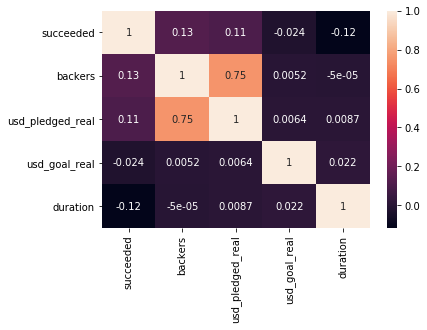

In [15]:
corr = df_clean.corr()
sns.heatmap(corr, annot=True);

None of the numerical variables have a strong linear correlation to the success of a project. Amount pledged has a strong positive correlation with number of backers. In order to limit multicollinearity in the machine learning model, I will use only one of these two highly correlated variables.

In [16]:
# drop usd_pledged_real to prevent multicollinearity from affecting model
df_clean.drop(['usd_pledged_real'], axis=1, inplace=True)

### Create dummy variables for categorical variables

In [17]:
# create dummy variables
df_clean = pd.get_dummies(df_clean)

In [18]:
df_clean.head()

,succeeded,backers,usd_goal_real,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,1533.95,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,15,30000.00,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,3,45000.00,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,5000.00,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,224,50000.00,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
df_clean.shape

(331654, 41)

There are now 40 features and 1 target variable (41 columns total).

### Transform numerical variables that are highly skewed

In [20]:
numerical = ['backers','usd_goal_real','duration']

# get descriptive statistics for original numerical variables
df_clean[numerical].describe()

,backers,usd_goal_real,duration
count,331654.000000,3.316540e+05,331654.000000
mean,116.388951,4.151218e+04,33.954920
std,965.457388,1.108965e+06,12.713587
min,0.000000,1.000000e-02,1.000000
25%,2.000000,2.000000e+03,30.000000
50%,15.000000,5.000000e+03,30.000000
75%,63.000000,1.500000e+04,36.000000
max,219382.000000,1.663614e+08,92.000000


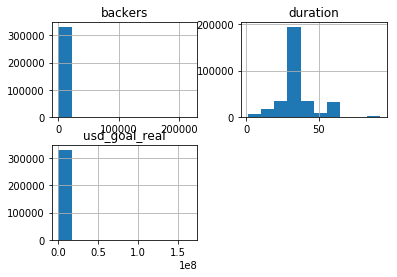

In [21]:
# plot histogram of values for numerical features
df_clean[numerical].hist();

It looks like backers and goal amount are highly skewed with many high outliers, because the max values are so much higher than the lowest 75%. Duration is relatively normally distributed (with just a few outliers cloer to 90). I will go ahead and log transform the backers and usd_goal_real columns in order to decrease the skewness.

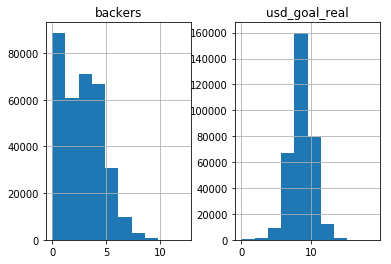

In [22]:
# log transform the numerical features
skewed = ['backers','usd_goal_real']
df_clean[skewed] = df_clean[skewed].apply(lambda x: np.log(x + 1))

# check
df_clean[skewed].hist();

### Standardize the numerical features

In [23]:
# Initialize a scaler, then apply it to the numerical features
scaler = RobustScaler() # most values will fall in [-2,3]
numerical = ['backers', 'duration', 'usd_goal_real']

df_scaled = pd.DataFrame(data=df_clean)
df_scaled[numerical] = scaler.fit_transform(df_scaled[numerical])

# confirm
df_scaled['backers'].head()

0   -0.905995
1    0.000000
2   -0.452997
3   -0.679496
5    0.863816
Name: backers, dtype: float64

### Build the logistic regression model

Let's get a quick overview of the pre-processed data before building the model.

In [24]:
df_scaled.succeeded.value_counts()

0    197702
1    133952
Name: succeeded, dtype: int64

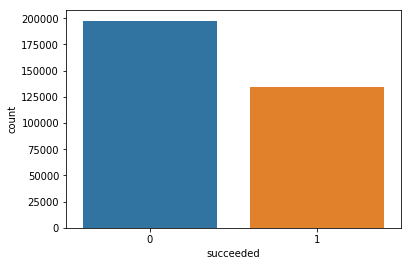

In [25]:
# create count plot
sns.countplot(x='succeeded', data=df_scaled);

In [26]:
# look at means for failed vs. succeeded
df_scaled.groupby('succeeded').mean()

,backers,usd_goal_real,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
succeeded,,,,,,,,,,,,,,,,,,,,,
0,-0.356502,0.185376,0.862239,0.071476,0.020415,0.028846,0.006247,0.074931,0.071729,0.166422,...,0.009762,0.000081,0.000192,0.005134,0.009074,0.002129,0.004178,0.005063,0.001396,0.769502
1,0.528327,-0.193420,0.359416,0.085926,0.043613,0.015789,0.017454,0.078752,0.041754,0.176354,...,0.003277,0.000052,0.000142,0.002956,0.004606,0.001217,0.003344,0.003800,0.001329,0.816554


In [27]:
y = df_scaled['succeeded'] # set target variable
X = df_scaled.drop(['succeeded'], axis=1) # set features

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.30, random_state=42)

In [28]:
# Instantiate model
lr_mod = LogisticRegression()

# fit model to training data
lr_mod.fit(X_train, y_train)

# get predictions for test set and training set
ytest_preds = lr_mod.predict(X_test)
ytrain_preds = lr_mod.predict(X_train)

In [29]:
# calculate testing and training set accuracies
test_acc = accuracy_score(y_test, ytest_preds) * 100
train_acc = accuracy_score(y_train, ytrain_preds) * 100

print ('The accuracy score for the test data is: {:.4f}%'.format(test_acc))
print ('The accuracy score for the training data is: {:.4f}%'.format(train_acc))

The accuracy score for the test data is: 93.0912%
The accuracy score for the training data is: 93.0125%


In [30]:
# calculate testing and training set f1-scores
test_f1 = f1_score(y_test, ytest_preds)
train_f1 = f1_score(y_train, ytrain_preds)

print ('The F1 score for the test data is: {:.4f}%'.format(test_f1))
print ('The F1 score for the training data is: {:.4f}%'.format(train_f1))

The F1 score for the test data is: 0.9153%
The F1 score for the training data is: 0.9147%


### Explore Question 4: Which features have the greatest influence on success?

Now we can look at the coefficients of the features in our model to see which features have the greatest influence on success.

In [31]:
# intitialize new dataframe
coefs_df = pd.DataFrame()

# get feature names and corresponding coefficients
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = lr_mod.coef_[0].tolist()
coefs_df['abs_coefs'] = np.abs(lr_mod.coef_[0].tolist()) #absolute value of coefficients

# sort dataframe by abs_coefs, display top 20
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False).head(20)
coefs_df

,feature,coefs,abs_coefs
0,backers,9.574378,9.574378
1,usd_goal_real,-3.897208,3.897208
11,main_category_Games,-2.031424,2.031424
28,country_HK,1.334142,1.334142
6,main_category_Dance,1.229893,1.229893
4,main_category_Comics,-1.185187,1.185187
22,country_CH,1.151776,1.151776
17,main_category_Theater,1.114728,1.114728
7,main_category_Design,-0.831899,0.831899
9,main_category_Film & Video,0.749341,0.749341


In [32]:
coefs_df.to_csv('coefs.csv', index=False)

From the table above, we can see that the number of backers has the greatest influence on success according to the model. The feature with the second largest influence is the goal amount, which has a negative relationship to success. Category and country also have a small influence on success.

### Explore Question 5: Can we predict success of current/future projects?

Obviously the number of backers may have changed for some of these projects as time went on. But we can try to predict which of the live projects will succeed based on how things were going at the time the data was pulled.

In [33]:
df_live = df[df.state == 'live']
df_live.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
40,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.0,live,24,CA,185.65,472.88,2396.36
183,1000761521,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,310.0,live,4,US,200.00,310.00,5000.00
458,1002183790,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,413.0,live,11,GB,13.39,563.32,1159.38
537,1002599057,Dear Atlantas,Film & Video,Film & Video,USD,2018-02-16,2000.0,2017-12-18 02:48:27,5.0,live,1,US,5.00,5.00,2000.00
544,1002629894,Art Calendar 2018,Illustration,Art,MXN,2018-01-06,1000.0,2017-12-21 05:34:12,0.0,live,0,MX,0.00,0.00,52.32


In [34]:
df_live.shape

(2799, 15)

In [35]:
df_live.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2799 entries, 40 to 378512
Data columns (total 15 columns):
ID                  2799 non-null int64
name                2799 non-null object
category            2799 non-null object
main_category       2799 non-null object
currency            2799 non-null object
deadline            2799 non-null object
goal                2799 non-null float64
launched            2799 non-null object
pledged             2799 non-null float64
state               2799 non-null object
backers             2799 non-null int64
country             2799 non-null object
usd pledged         2798 non-null float64
usd_pledged_real    2799 non-null float64
usd_goal_real       2799 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 349.9+ KB


There are 2799 projects marked as live in this dataset, with no missing values. Let's look at how many of these live projects already succeeded even though they did not yet reach the deadline at the time the data was pulled (i.e. the projects who have a greater pledged amount than goal amount).

In [36]:
# get live projects that already have a higher pledgeed amt than goal amt
live_succeeded = df_live[df_live.usd_pledged_real > df_live.usd_goal_real]

In [37]:
percent_already_succeeded = len(live_succeeded)/len(df_live) * 100
percent_already_succeeded

15.326902465166132

Around 15% of these live projects already succeeded at the time of the data collection.

In [38]:
# turn off warning print-outs
import warnings
warnings.simplefilter('ignore')

In [39]:
# clean data to use with model
df_live = kml.clean_data(df_live)

In [40]:
df_live.head()

,succeeded,backers,usd_goal_real,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
40,NaN,3.218876,7.782123,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,NaN,1.609438,8.517393,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
458,NaN,2.484907,7.056503,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537,NaN,0.693147,7.601402,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
544,NaN,0.000000,3.976311,16,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [41]:
# apply scaler to df_live numerical features (don't re-fit)
numerical = ['backers', 'duration', 'usd_goal_real']
df_live_scaled = pd.DataFrame(data=df_live)
df_live_scaled[numerical] = scaler.transform(df_live_scaled[numerical])

# check
df_live_scaled.backers.head()

40     0.145833
183   -0.380081
458   -0.094005
537   -0.679496
544   -0.905995
Name: backers, dtype: float64

In [42]:
# drop 'succeeded' column since that's what we're trying to predict
X_live = df_live_scaled.drop(['succeeded'], axis=1)

In [43]:
# get predictions for live projects
live_preds = lr_mod.predict(X_live)

In [44]:
# convert predictions into dataframe
live_preds_df = pd.DataFrame(live_preds)
live_preds_df.columns = ['succeeded']

In [45]:
# get predicted success rate of live projects
success_rate_live = live_preds_df.succeeded.mean()
print ('The predicted success rate for the live projects in the dataset is: {:.2f}%'.format(success_rate_live*100))

The predicted success rate for the live projects in the dataset is: 23.90%


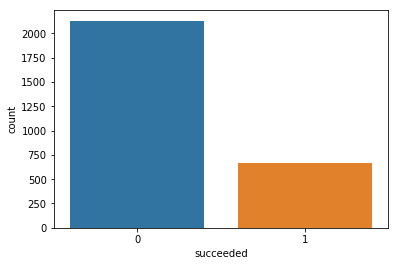

In [46]:
# create count plot
sns.countplot(x='succeeded', data=live_preds_df);

From this model, we can predict that 24% of the live projects will succeed based on the information we have (~9% more than already succeeded).

### Explore Question 5, continued: Build model without using number of backers

Before a project goes live, we will not know the number of backers. Therefore, a model that can predict the outcome of a project before it goes live would be helpful. So let's now build a model that does not use the number of backers as a feature - we can assume this will decrease the accuracy though since we found that number of backers is the biggest indicator of success.

In [47]:
y = df_scaled['succeeded'] # set target variable
X = df_scaled.drop(['succeeded','backers'], axis=1) # set features

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.30, random_state=42)

In [48]:
# Instantiate model
lr_mod2 = LogisticRegression()

# fit model to training data
lr_mod2.fit(X_train, y_train)

# get predictions for test data
ytest_preds2 = lr_mod2.predict(X_test)
ytrain_preds2 = lr_mod2.predict(X_train)

In [49]:
# calculate testing and training set accuracies with this new model
test_acc2 = accuracy_score(y_test, ytest_preds2) * 100
train_acc2 = accuracy_score(y_train, ytrain_preds2) * 100

print ('The accuracy score for the test data is: {:.4f}%'.format(test_acc2))
print ('The accuracy score for the training data is: {:.4f}%'.format(train_acc2))

The accuracy score for the test data is: 65.0834%
The accuracy score for the training data is: 64.8591%


In [50]:
# calculate testing and training set f1-scores with this new model
test_f1_2 = f1_score(y_test, ytest_preds2)
train_f1_2 = f1_score(y_train, ytrain_preds2)

print ('The F1 score for the test data is: {:.4f}%'.format(test_f1_2))
print ('The F1 score for the training data is: {:.4f}%'.format(train_f1_2))

The F1 score for the test data is: 0.4832%
The F1 score for the training data is: 0.4813%


As expected, the accuracy and f1-score went down for this model. Trying different types of models and performing optimization could help increase these scores.

Let's go ahead and predict the outcomes without backers anyway.

In [51]:
# get predictions for live projects using model without backers column
X_live = X_live.drop('backers', axis=1)

live_preds2 = lr_mod2.predict(X_live)

In [52]:
live_preds_df2 = pd.DataFrame(live_preds2)
live_preds_df2.columns = ['succeeded']

In [53]:
# convert predictions into dataframe
success_rate_live2 = live_preds_df2.succeeded.mean()
print ('The predicted success rate for the live projects in the dataset is: {:.2f}%'.format(success_rate_live2*100))

The predicted success rate for the live projects in the dataset is: 18.26%


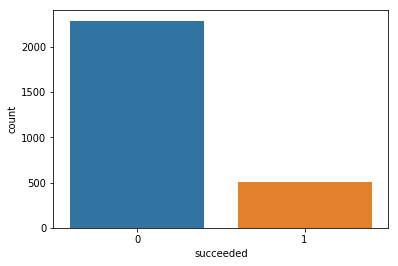

In [54]:
# create countplot
sns.countplot(x='succeeded', data=live_preds_df2);

Without using backers, we can predict that around 18% of the live projects will succeed based on the information we have (~3% more than already succeeded).

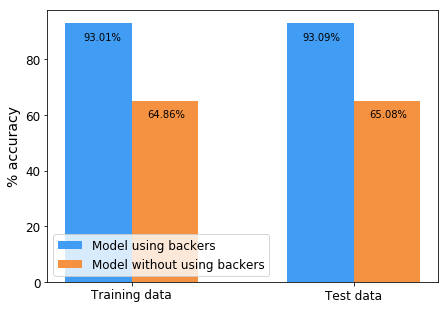

In [55]:
# graph accuracy of model with backers and model without backers
# plot pledged and goal medians for failed vs. successful projects
with_b_heights = [train_acc, test_acc]
without_b_heights = [train_acc2, test_acc2]

ind = np.arange(0,2)
labels = ['Training data','Test data']

width = 0.3

plt.figure(figsize=(7,5))
plt.bar(ind, with_b_heights, width, color='#419df4', label='Model using backers')
plt.bar(ind+width, without_b_heights, width, color='#f49242', label='Model without using backers')
plt.xticks(ind+0.15, labels, size=12)
plt.yticks(size=12)
plt.ylabel('% accuracy', size=14)
plt.legend(loc=3, prop={'size': 12})

# add values to bars
plt.text(-0.07,87,'{:.2f}%'.format(with_b_heights[0]))
plt.text(0.22,59,'{:.2f}%'.format(without_b_heights[0]))
plt.text(0.92,87,'{:.2f}%'.format(with_b_heights[1]))
plt.text(1.22,59,'{:.2f}%'.format(without_b_heights[1]))

# save figure
plt.savefig('model_accuracy.png', bbox_inches='tight');